In [1]:
import pandas as pd
import pickle
import os
import json
import re
from PIL import Image
import pprint
from scipy.stats import norm
prettyprint = pprint.PrettyPrinter(indent=4)

In [2]:
%reload_ext autoreload
%autoreload 2
import sys
sys.path.append('../../')

In [34]:
import os
import locale
locale.setlocale(locale.LC_TIME, "it_IT.UTF8")

from datetime import datetime, timedelta
from matplotlib import pyplot as plt, dates as mdates
import numpy as np
import pandas as pd
from scipy import stats
from sklearn.metrics import mean_squared_error
import pymc3 as pm

from covid19_pytoolbox.settings import BASE_DATA_PATH, BASE_IMAGES_PATH
from covid19_pytoolbox import plotting
from covid19_pytoolbox.italy.data import ISS
from covid19_pytoolbox.italy.data import DPC
from covid19_pytoolbox.smoothing.seasonalRSVD.LogRSVD import LogSeasonalRegularizer
from covid19_pytoolbox.smoothing.tikhonovreg import TikhonovRegularization
from covid19_pytoolbox.modeling.datarevision.seasonal import draw_expanded_series, smooth_and_drop
from covid19_pytoolbox.modeling.Rt.bayesian import MCMC_sample
from covid19_pytoolbox.utils import smape, padnan

BASE_DATA_PATH='../../data'
BASE_IMAGES_PATH='../../images'

In [4]:
alpha = 1.87
beta = 0.28

ALPHA=100.

In [5]:
local_imported = pd.read_csv(
    os.path.join(BASE_DATA_PATH, 'sources/ISS_daily_local_imported/curva_epidemica_Italia_2021-07-07'),
    names=["data", "local", "imported"],
    parse_dates=["data"],
    sep=" "
)

In [42]:
local_imported['dayofyear'] = local_imported.data.dt.dayofyear.astype(float)

In [6]:
local_imported["total"] = local_imported.local+local_imported.imported
local_imported["imported_ratio_100"] = 100*local_imported.imported/local_imported.total

In [7]:
local_imported['imported_ratio_100_avg14'] = local_imported.imported_ratio_100.rolling(window=14, min_periods=1).mean()
local_imported['imported_ratio_100_std14'] = local_imported.imported_ratio_100.rolling(window=14, min_periods=1).std()

In [8]:
local_imported['imported_ratio_100_CI_min'], local_imported['imported_ratio_100_CI_max'] = norm.interval(
    0.95, 
    loc=local_imported.imported_ratio_100_avg14, 
    scale=local_imported.imported_ratio_100_std14
)

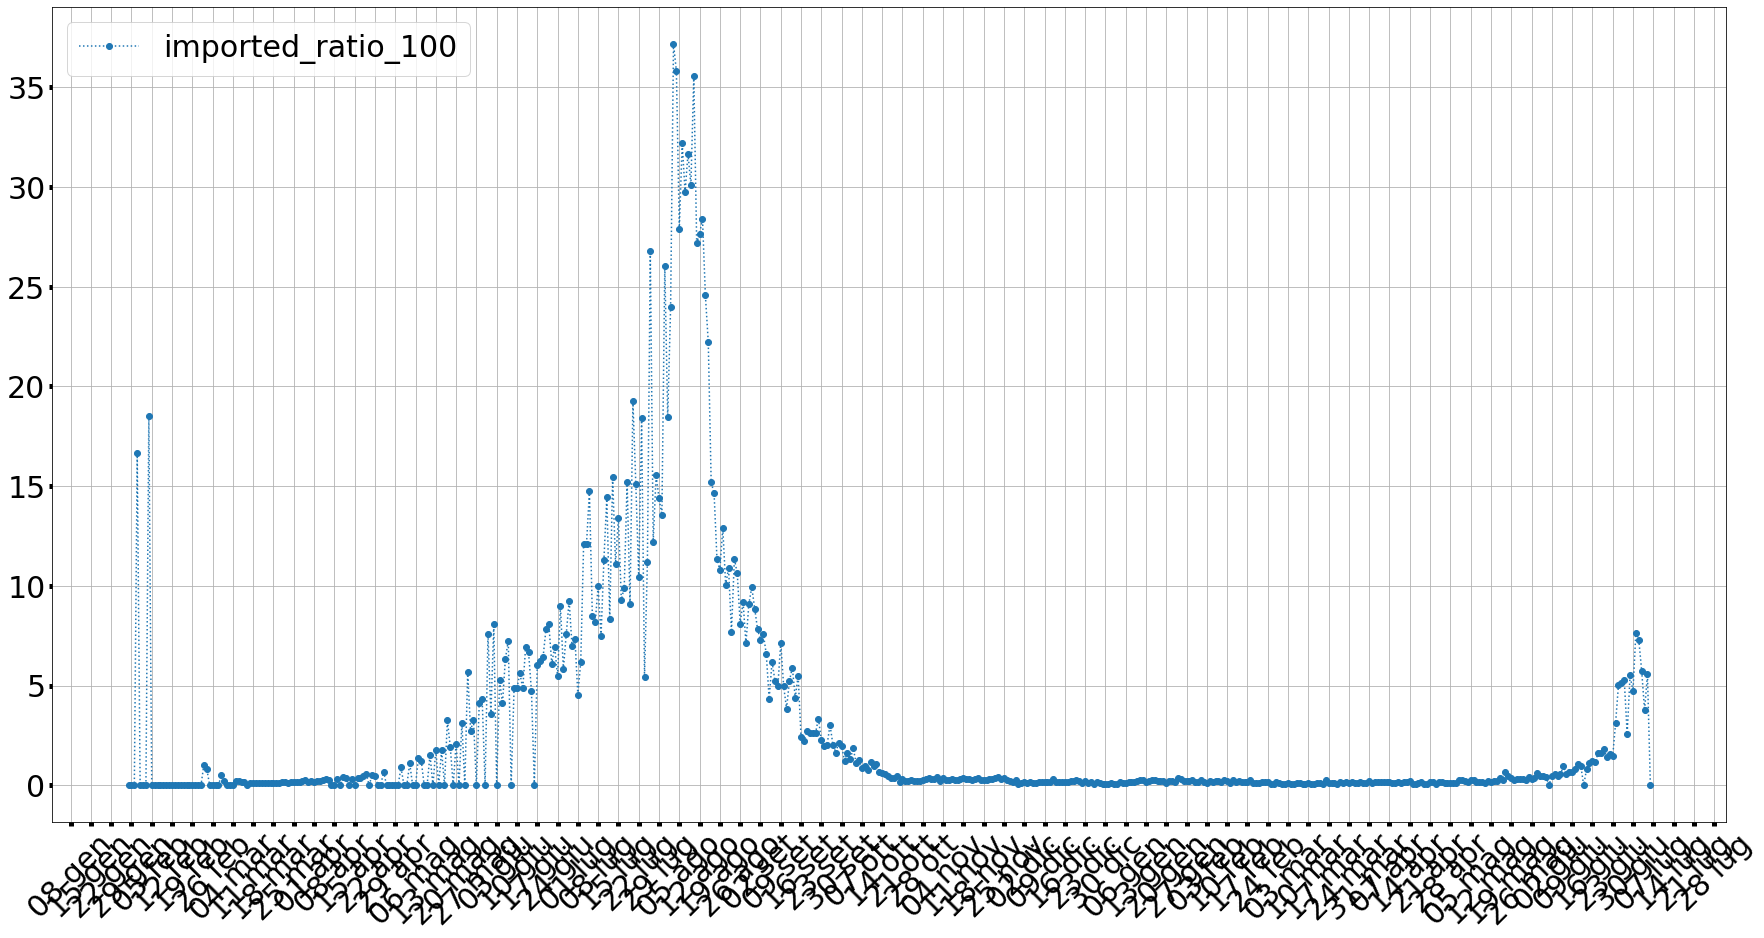

In [9]:
plotting.plot_series(
    df=local_imported,
    yfields=[
        'imported_ratio_100', 
    ],
    #xlim=(datetime(2020,7,25), datetime(2020,10,1)),#DPC_data.data.max()),
    #ylim=(-1000,1000),
    #xlim=(datetime(2020,12,1), DPC_data.data.max()),
    #ylim=(-10000,40000),
    legend_loc="upper left"
)

In [10]:
def RSVD_smooth_data(df, alpha, beta, season_period=7, trend_alpha=100., difference_degree=3):

    initial_cols = df.columns

    filter_columns = [
        'total',
        'imported',
    ]

    prettyprint.pprint(filter_columns)

    for col in filter_columns:
        smoothcol = col+'_deseason'
        print(smoothcol)

        lrsvd = LogSeasonalRegularizer(
            df[col],
            season_period=season_period, max_r=season_period,
            trend_alpha=trend_alpha, difference_degree=difference_degree, verbose=True)

        m = lrsvd.fit()
        print(f'patterns: {m.final_r}')

        df[f'{smoothcol}'] = m.deseasoned
        df[f'{smoothcol}_seasonality'] = m.season_svd
        df[f'{smoothcol}_smoothed'] = m.trend
        df[f'{smoothcol}_residuals'] = m.residuals
        df[f'{smoothcol}_relative_residuals'] = m.relative_residuals

        prettyprint.pprint(lrsvd.adfuller())

        print('new columns generated:')
        prettyprint.pprint([c for c in df.columns if c not in initial_cols])

In [11]:
RSVD_smooth_data(local_imported, alpha=alpha, beta=beta, difference_degree=6, trend_alpha=ALPHA)

['total', 'imported']
total_deseason
info_cri:  1.9625857444954513
info_cri:  2.473229264752645
TIC R2: 0.9938246131422092
patterns: 1
(   -15.089913986512935,
    8.221529229165323e-28,
    19,
    499,
    {   '1%': -3.4435228622952065,
        '10%': -2.569864247011056,
        '5%': -2.867349510566146},
    -84.0379144680794)
new columns generated:
[   'total_deseason',
    'total_deseason_seasonality',
    'total_deseason_smoothed',
    'total_deseason_residuals',
    'total_deseason_relative_residuals']
imported_deseason
info_cri:  5.191080597881153
info_cri:  11.88962787846329
TIC R2: 0.844346091344966
patterns: 1
(   -17.754939020469596,
    3.357561672514259e-30,
    19,
    499,
    {   '1%': -3.4435228622952065,
        '10%': -2.569864247011056,
        '5%': -2.867349510566146},
    1233.5766340898203)
new columns generated:
[   'total_deseason',
    'total_deseason_seasonality',
    'total_deseason_smoothed',
    'total_deseason_residuals',
    'total_deseason_relative_re

In [12]:
local_imported["imported_ratio_100_deseason_smoothed"] = \
    100*local_imported.imported_deseason_smoothed/local_imported.total_deseason_smoothed

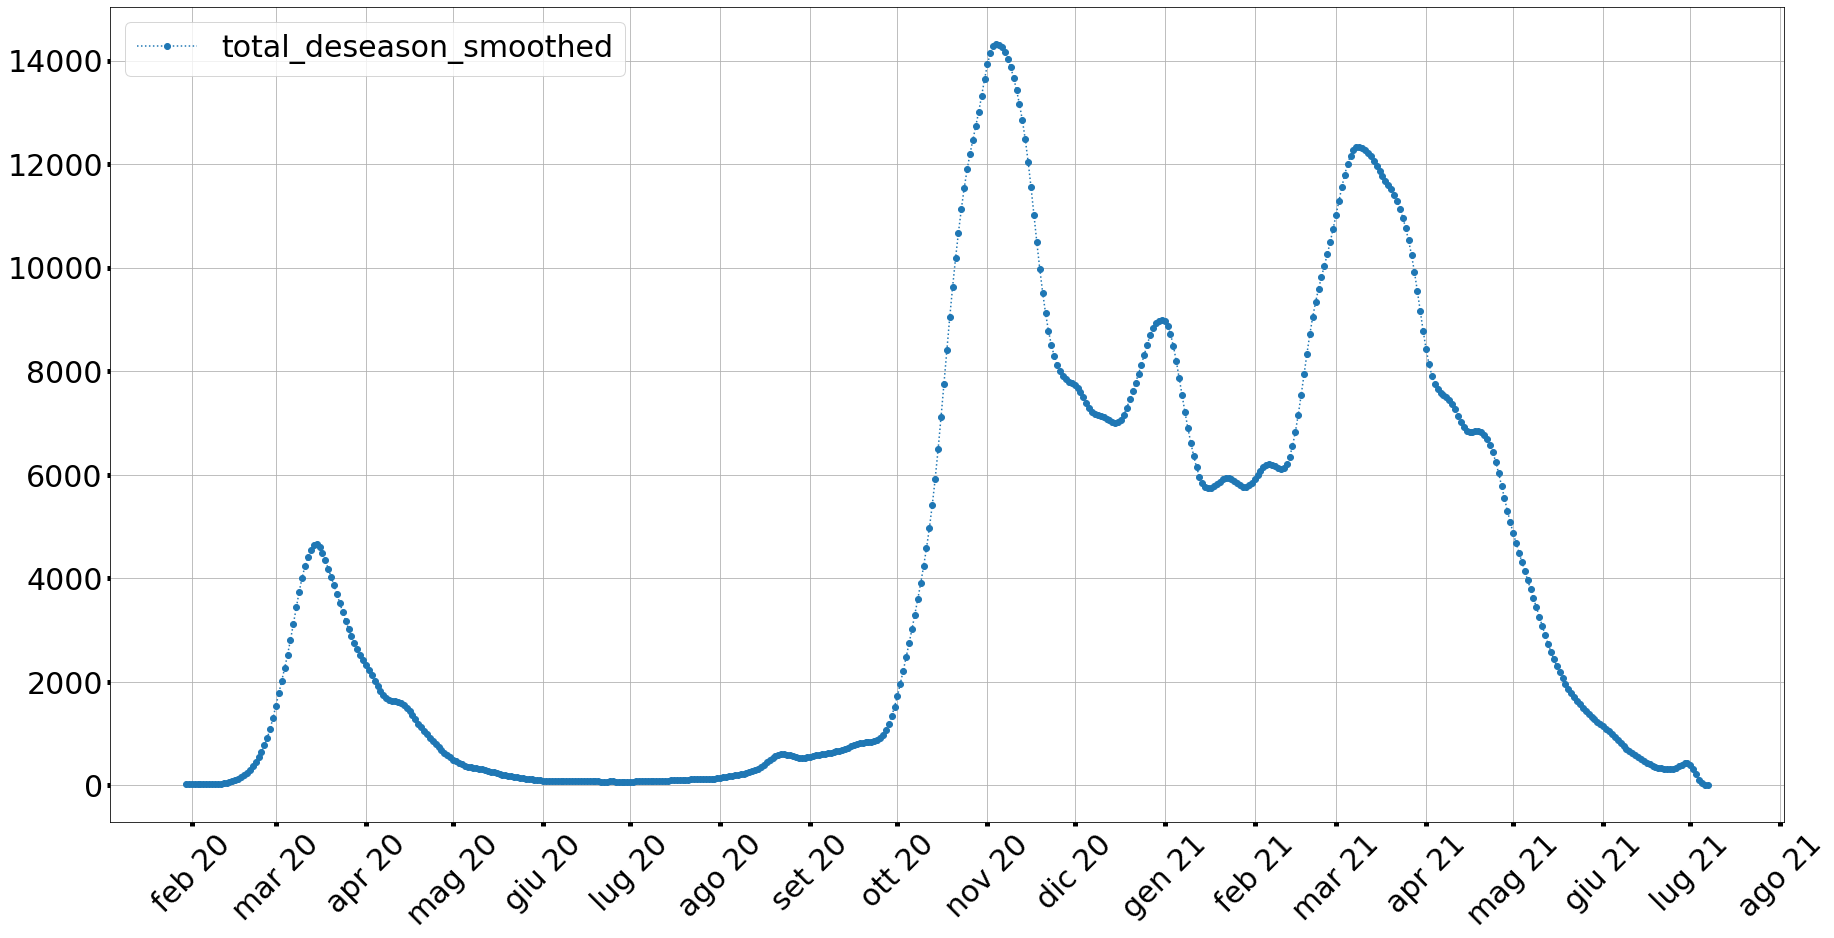

In [49]:
plotting.plot_series(
    df=local_imported,
    yfields=[
        'total_deseason_smoothed',
    ],
    major_locator=mdates.MonthLocator(bymonthday=1),
    major_formatter=mdates.DateFormatter("%b %y"),    
    legend_loc="upper left"
)

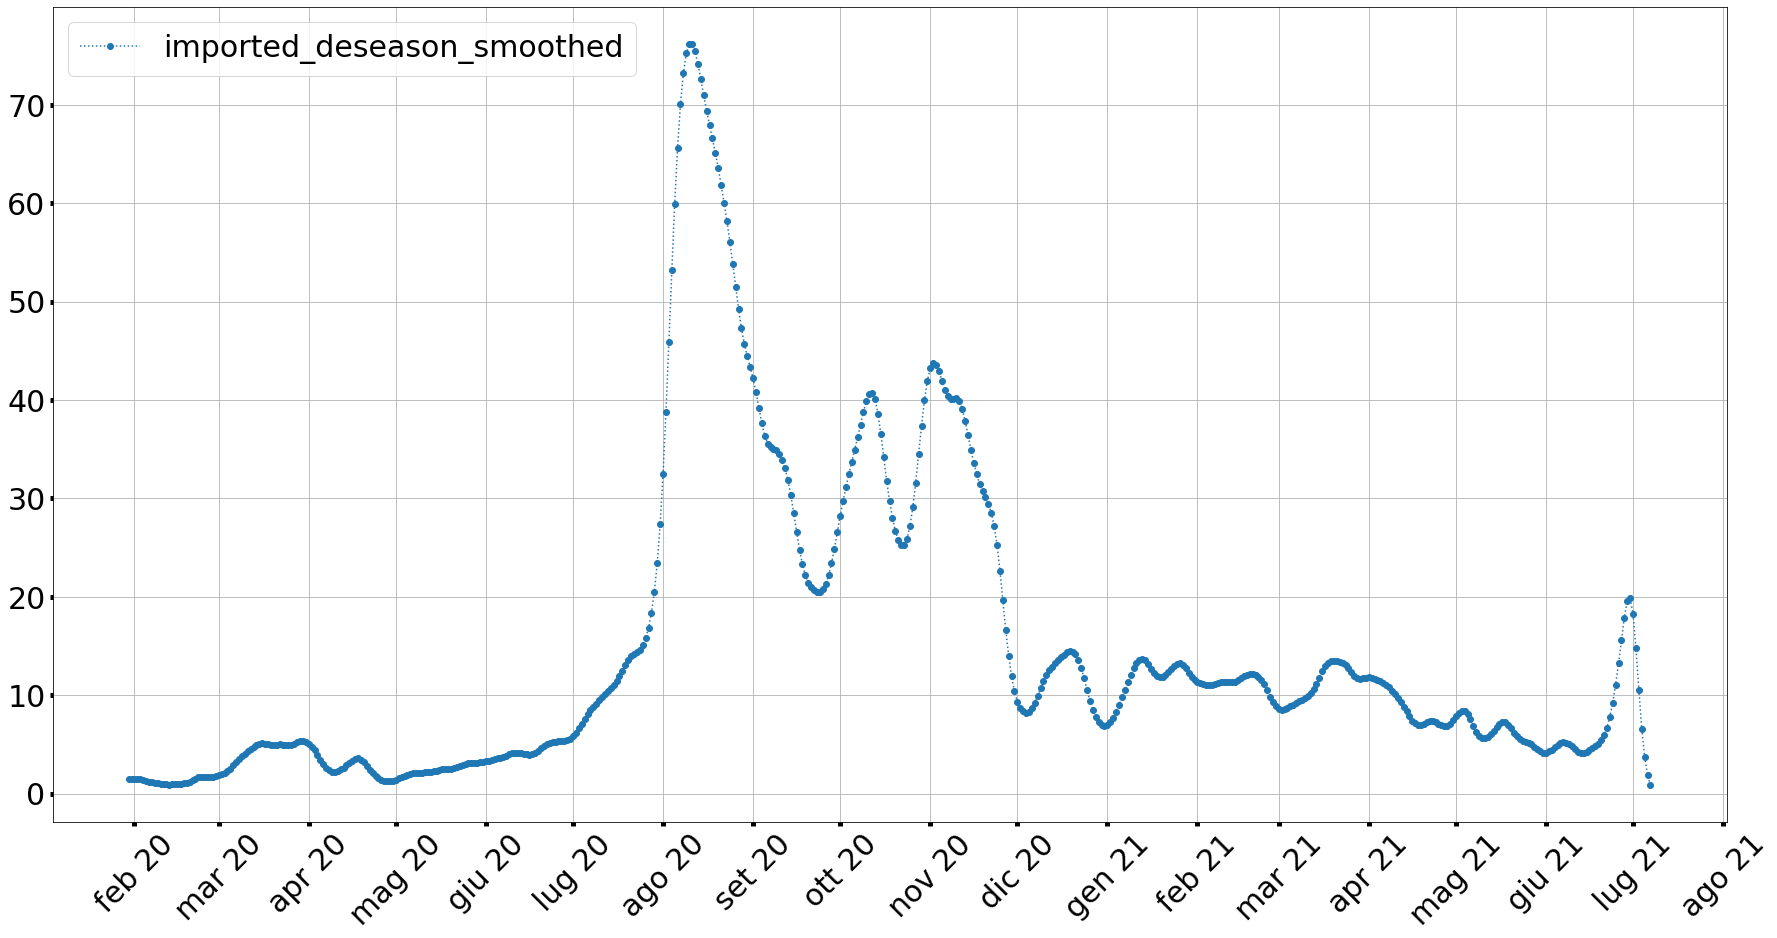

In [50]:
plotting.plot_series(
    df=local_imported,
    yfields=[
        'imported_deseason_smoothed',
    ],
    major_locator=mdates.MonthLocator(bymonthday=1),
    major_formatter=mdates.DateFormatter("%b %y"),    
    legend_loc="upper left"
)

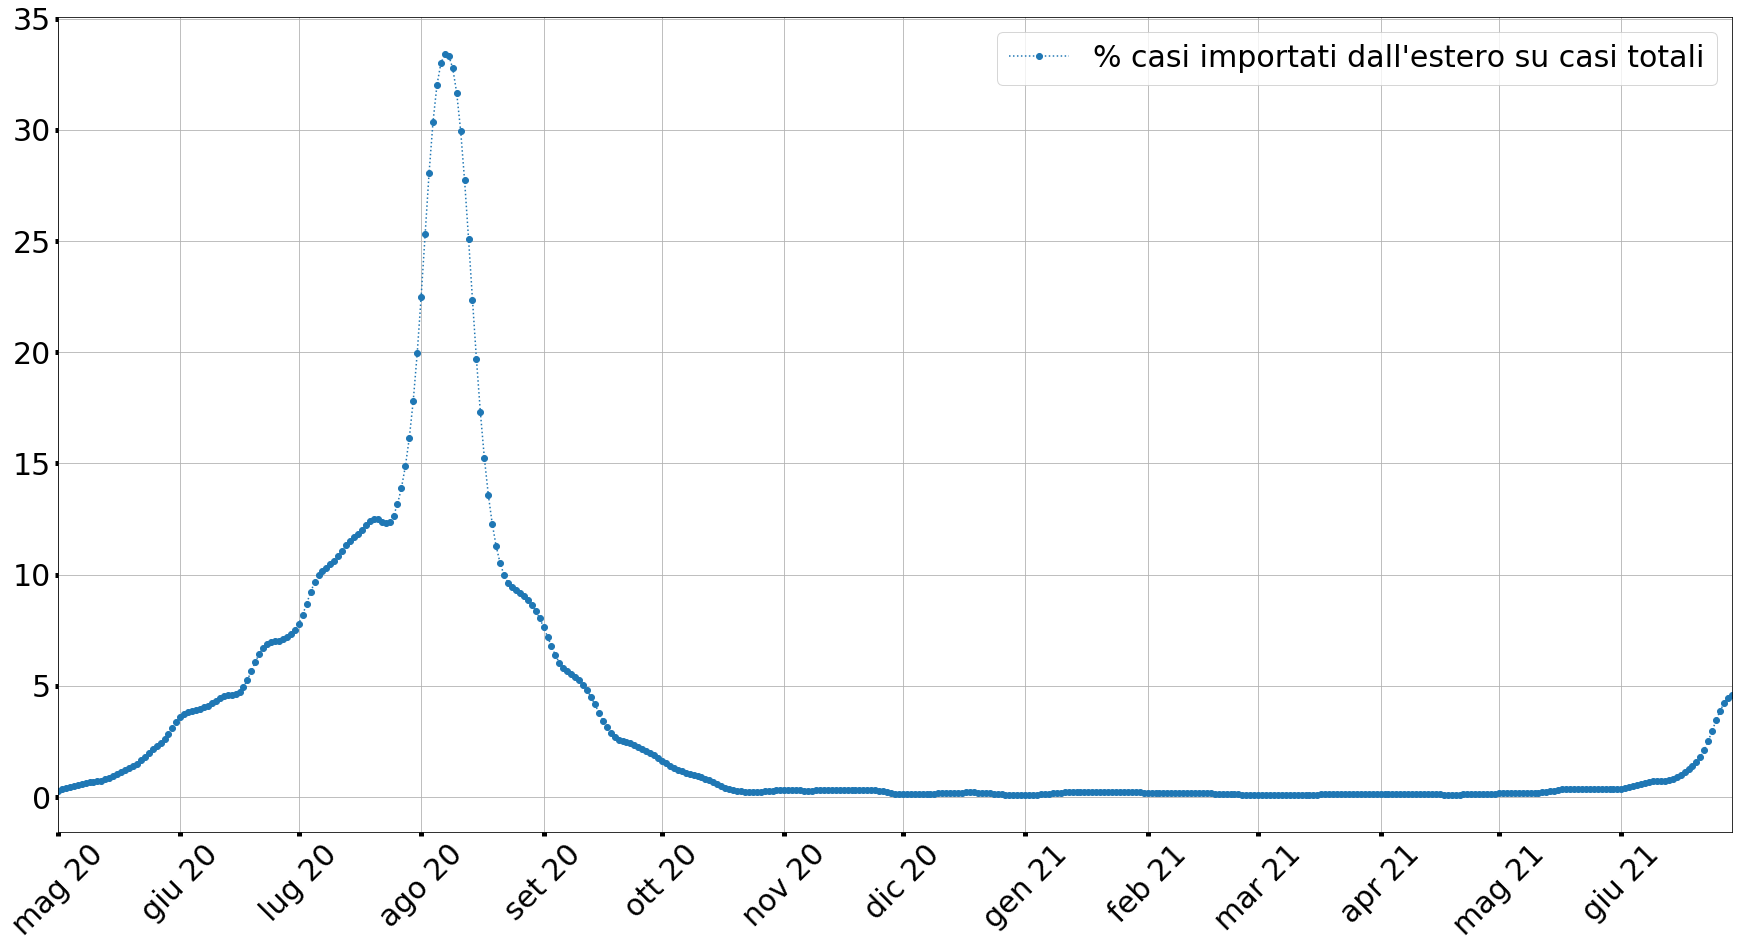

In [39]:
plotting.plot_series(
    data=[{
        'df': local_imported,
        'xfield': 'data',
        'yfields': [
            'imported_ratio_100_deseason_smoothed', 
        ],
        'labels':[
            '% casi importati dall\'estero su casi totali'
        ]
    }],
    xlim=(datetime(2020,5,1), datetime(2021,6,29)),
    legend_loc="upper right",
    major_locator=mdates.MonthLocator(bymonthday=1),
    major_formatter=mdates.DateFormatter("%b %y"),
    img_file_path_without_extension=os.path.join(BASE_IMAGES_PATH,'italy/importati_perc_global'),
    quality=40
)

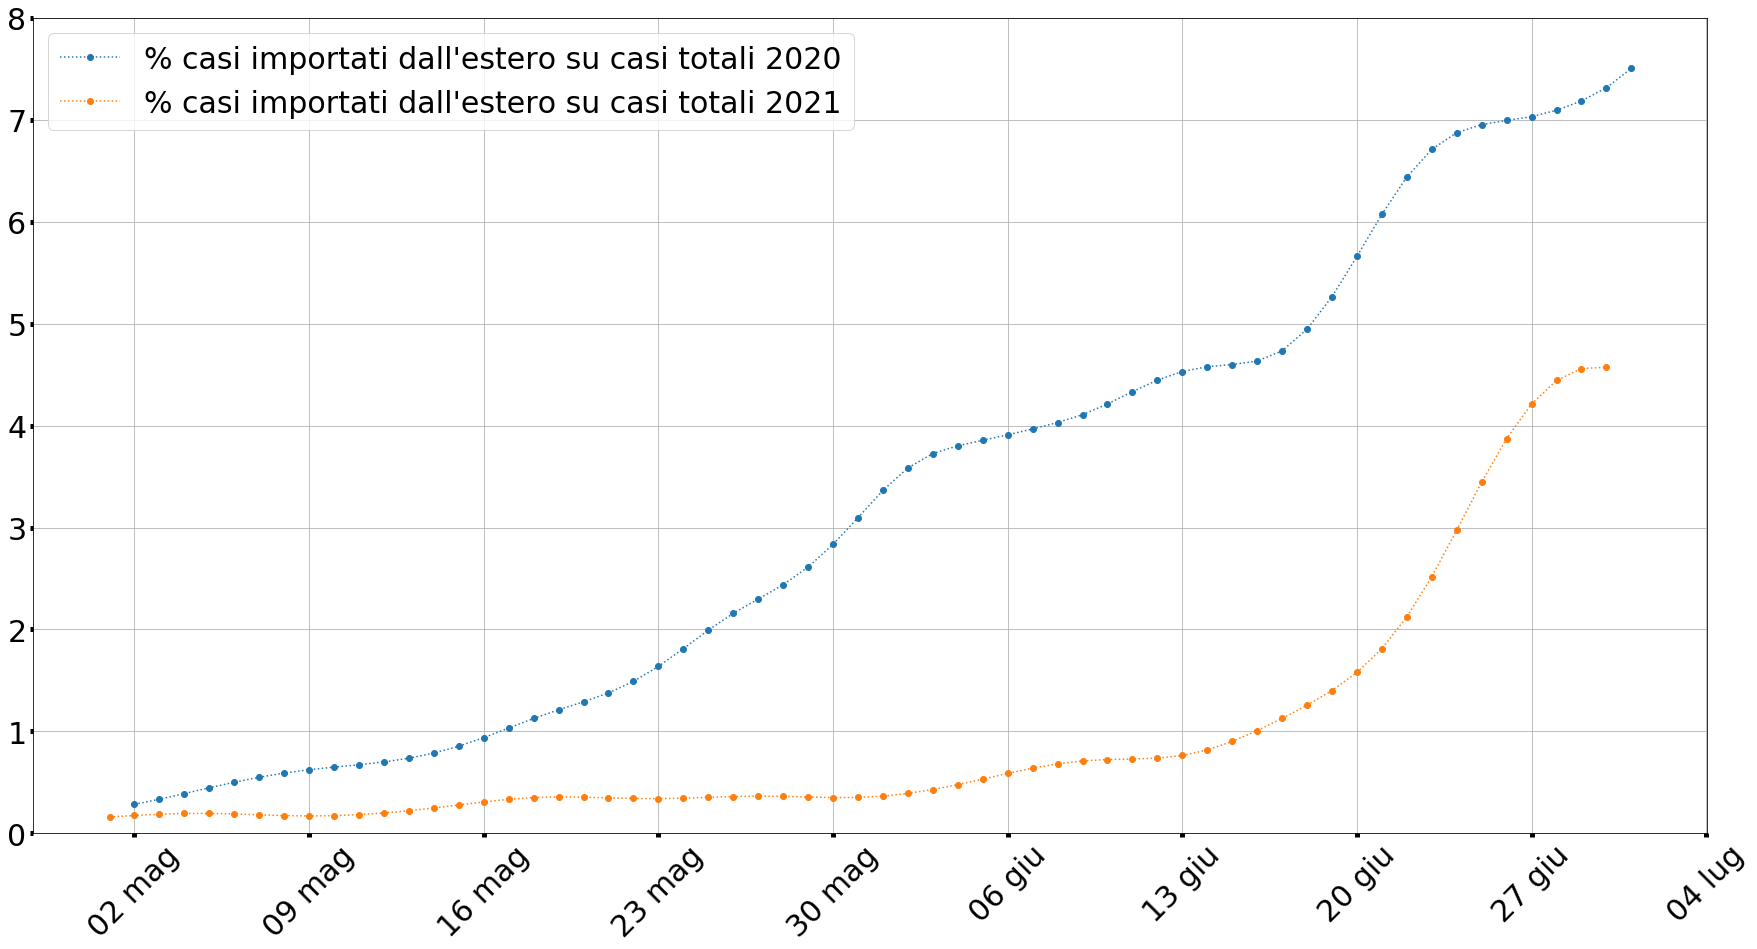

In [44]:
plotting.plot_series(
    data=[
        {
            'df': local_imported[(local_imported.data>="2020-05-01") & (local_imported.data<="2020-06-30")],
            'xfield': 'dayofyear',
            'yfields': [
                'imported_ratio_100_deseason_smoothed', 
            ],
            'labels':[
                '% casi importati dall\'estero su casi totali 2020'
            ]
        },
        {
            'df': local_imported[(local_imported.data>="2021-05-01") & (local_imported.data<="2021-06-30")],
            'xfield': 'dayofyear',
            'yfields': [
                'imported_ratio_100_deseason_smoothed', 
            ],
            'labels':[
                '% casi importati dall\'estero su casi totali 2021'
            ]
        },        
    ],
    ylim=(0,8),
    legend_loc="upper left",
    img_file_path_without_extension=os.path.join(BASE_IMAGES_PATH,'italy/importati_perc_zoom_2020_2021'),
    quality=40
)

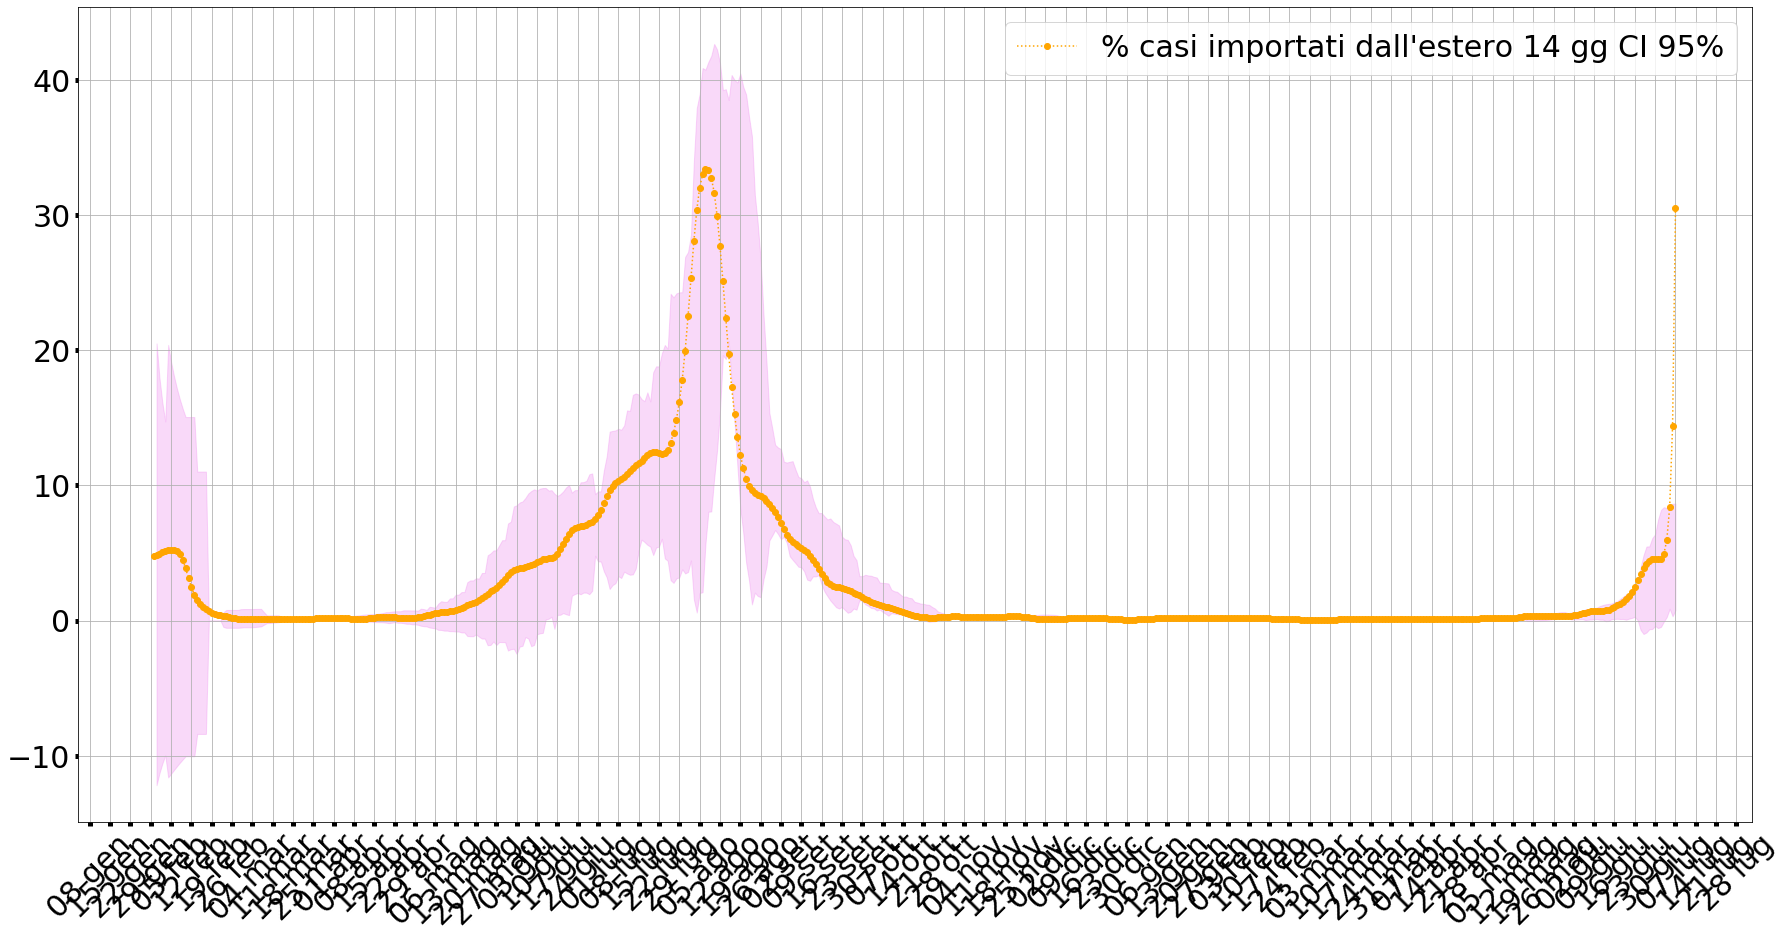

In [47]:
plotting.plot_series(
    data=[
        {
            'df': local_imported,
            'xfield': 'data',
            'yfields': [
                'imported_ratio_100_deseason_smoothed', 
            ],
            'fill_between': [
                'imported_ratio_100_CI_min',
                'imported_ratio_100_CI_max',
            ],
            'labels': [
                '% casi importati dall\'estero 14 gg CI 95%',
            ],
            'colors':['orange']
        },        
    ],
    #xlim=(datetime(2020,7,25), datetime(2020,10,1)),#DPC_data.data.max()),
    #ylim=(-1000,1000),
    #xlim=(datetime(2021,5,1), datetime(2021,7,7)),
    #ylim=(0,8),
    legend_loc="upper right"
)

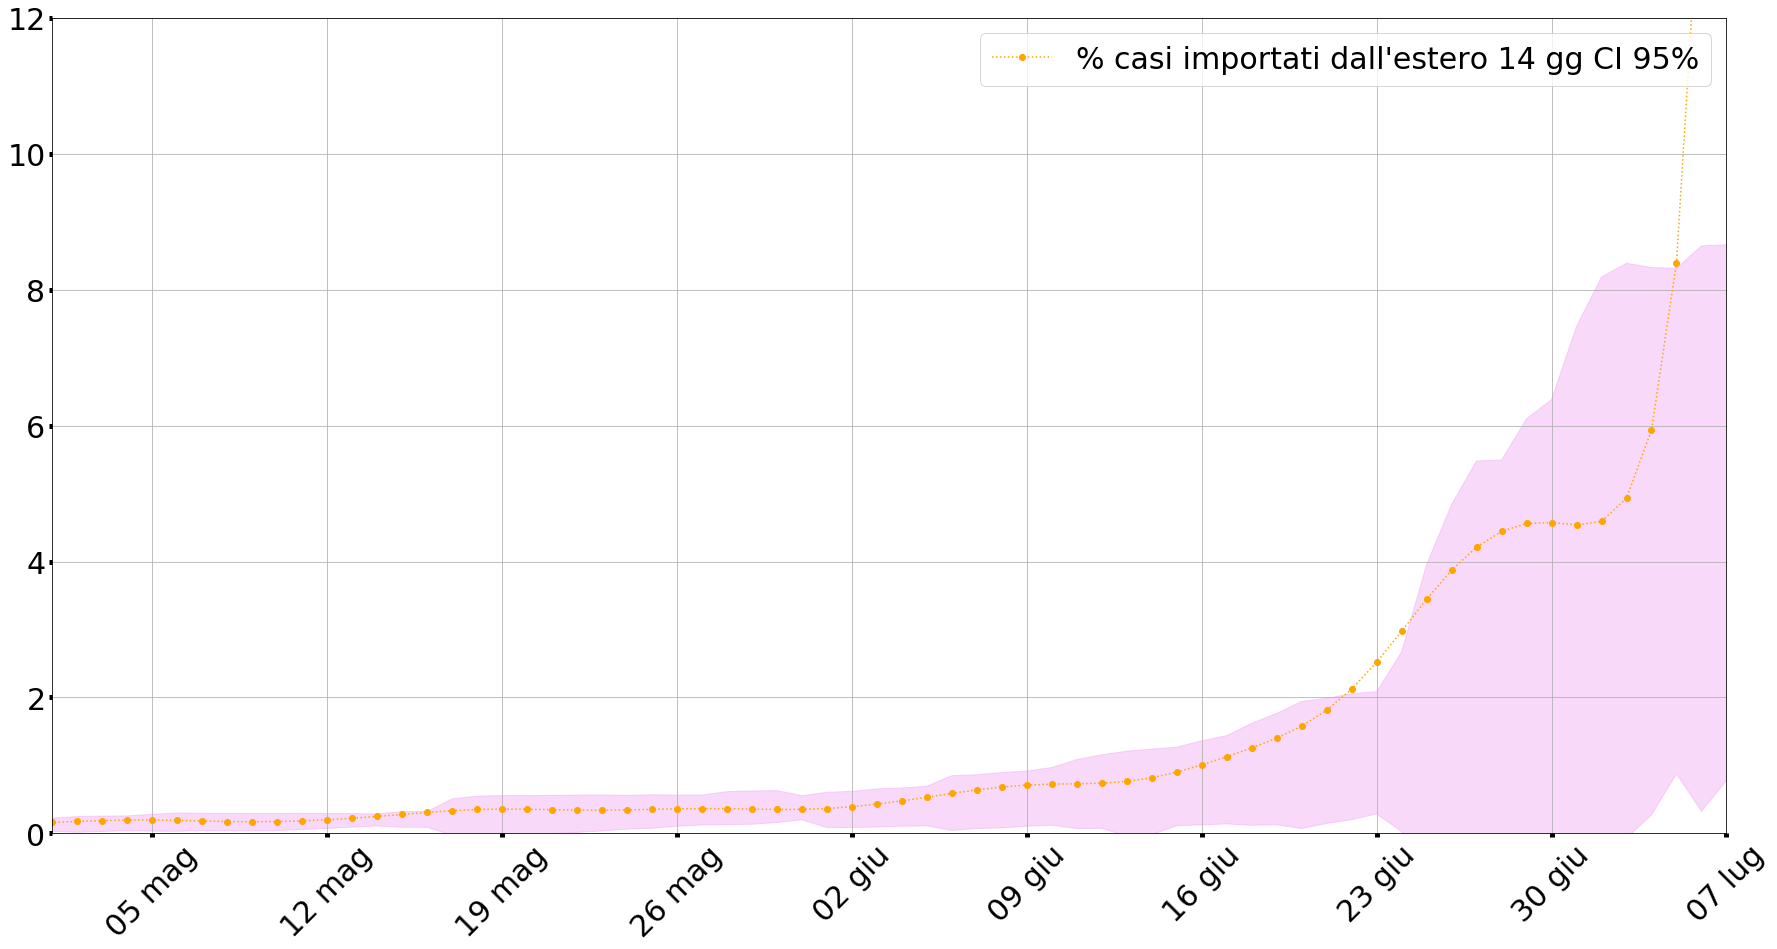

In [48]:
plotting.plot_series(
    data=[
        {
            'df': local_imported,
            'xfield': 'data',
            'yfields': [
                'imported_ratio_100_deseason_smoothed', 
            ],
            'fill_between': [
                'imported_ratio_100_CI_min',
                'imported_ratio_100_CI_max',
            ],
            'labels': [
                '% casi importati dall\'estero 14 gg CI 95%',
            ],
            'colors':['orange']
        },        
    ],
    #xlim=(datetime(2020,7,25), datetime(2020,10,1)),#DPC_data.data.max()),
    #ylim=(-1000,1000),
    xlim=(datetime(2021,5,1), datetime(2021,7,7)),
    ylim=(0,12),
    legend_loc="upper right"
)

In [26]:
local_imported.imported_ratio_100.rolling(window=14, min_periods=1).mean()

0      0.000000
1      0.000000
2      0.000000
3      4.166667
4      3.333333
         ...   
522    4.158728
523    4.298556
524    4.595621
525    4.484014
526    4.718098
Name: imported_ratio_100, Length: 527, dtype: float64

In [27]:
local_imported.imported_ratio_100.rolling(window=14).mean()

0           NaN
1           NaN
2           NaN
3           NaN
4           NaN
         ...   
522    4.158728
523    4.298556
524    4.595621
525    4.484014
526         NaN
Name: imported_ratio_100, Length: 527, dtype: float64

In [58]:
local_imported[['data','imported_ratio_100_deseason_smoothed']].tail(60)

,data,imported_ratio_100_deseason_smoothed
467,2021-05-09,0.170484
468,2021-05-10,0.173414
469,2021-05-11,0.183273
470,2021-05-12,0.199696
471,2021-05-13,0.221899
472,2021-05-14,0.248633
473,2021-05-15,0.278192
474,2021-05-16,0.307844
475,2021-05-17,0.333671
476,2021-05-18,0.350997
